In [69]:
# from sst and rainfall ---> rainfall
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.compat.v1 as tf
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sc
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

add_data = "/home/cccr/roxy/matin/MTech_project/data/"

# Actual Filtered Data

In [7]:
def filter_signal_scipy(signal,sample_freq,ltime_period,htime_period,keep_mean):
    filter_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf=1./ltime_period
        lf=1./htime_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1=(np.abs(fftfreq) >= lf) & (np.abs(fftfreq) <= hf)  
        inv_fft=np.zeros(temp_fft.size,dtype=complex)
        inv_fft[i1]=temp_fft[i1]
        if keep_mean:
            inv_fft[0]=temp_fft[0]
        filter_signal= np.real_if_close(sc.fftpack.ifft(inv_fft))
    
    return filter_signal

def norm_anom_var(var):
    mean_var = np.mean(var)
    anom_var = var - mean_var
    std_var = np.std(var)
    norm_anom_var = anom_var / std_var
    return norm_anom_var

rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]

n_rf = rf
for i in range(0,39):
    for j in range(0,25):
        n_rf[:,j,i] = norm_anom_var(rf[:,j,i])
n_sst = sst        
for i in range(0,39):
    for j in range(0,25):
        n_sst[:,j,i] = norm_anom_var(sst[:,j,i])


sample_freq = 1
ltime_period = 30
htime_period = 60
keep_mean = 0

filtered_rf = n_rf
for i in range(0,39):
    for j in range(0,25):
        filtered_rf[:,j,i] = filter_signal_scipy(n_rf[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)
filtered_sst = n_sst
for i in range(0,39):
    for j in range(0,25):
        if any(np.isnan(n_sst[:,j,i].values)):
            pass
        else:
            filtered_sst[:,j,i] = filter_signal_scipy(n_sst[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)

In [9]:
rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")

rf_mon = rf.isel(time=rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Frf_mon = filtered_rf.isel(time=filtered_rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))

new_time = Frf_mon.sel(time=slice("2017-06-20","2017-10-12")).time.data

rf_mean = Frf_mon.mean(dim = ['lon', 'lat']).sel(time=slice("2017-06-08","2017-09-30")).assign_coords(time=new_time)
rf_std = rf_mean.std().data
print("First Std Deviation for RF monsoon DATA = ",rf_mean.std().data)


First Std Deviation for RF monsoon DATA =  0.11723878234624863


# Prediction

In [1]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-06-01","2017-10-30"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out



In [12]:
def In_Out(lead_time, channels, steps):
    input = create_input(channels, steps)
    channel_data = xr.open_dataarray(add_data + channels[0])
    _, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
    target = np.expand_dims(target, axis=1)
    
    # Roll axes for input and target
    x = np.rollaxis(input, 4, 2)
    x = np.rollaxis(x, 4, 2)

    y = np.rollaxis(target, 3, 1)
    y = np.rollaxis(y, 3, 1)

    # Assert that input and target shapes are consistent
    assert input.shape[0] == target.shape[0]
    assert input.shape[-1] == target.shape[-1]
    assert input.shape[-2] == target.shape[-2]


    # Print shape of input and target
    print("INPUT SHAPE --> ", input.shape)
    print("TARGET SHAPE --> ", target.shape)

    # Delete original input and target variables to free up memory
    del input
    del target
    return x,y



In [58]:
sequence = channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_13lag.nc")
sequence = sequence.sel(time=slice("2017-06-01","2017-10-30"))
sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
max = sequence.max()
min = sequence.min()


In [70]:
xr.open_dataarray(add_data + "FilteredrfBOB_13lag.nc")[1].data

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [71]:
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_13lag.nc")
channel_data[1].data

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [59]:
lead_time = 0
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in1out/"
model_path = save_path + "ConvLstm_sst13rf_rf_0bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,115):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-20","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-20","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-20","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq1 = pred_seq*(max - min)+min 
pred_seq1

Adding channel 0 with shape: (115, 7, 1, 25, 39)
Adding channel 1 with shape: (115, 7, 1, 25, 39)
INPUT SHAPE -->  (115, 7, 2, 25, 39)
TARGET SHAPE -->  (115, 1, 25, 39)
4/4 [==============================] - 5s 306ms/step
nan


/home/cccr/roxy/panini/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cccr/roxy/panini/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<xarray.DataArray (time: 115, lat: 25, lon: 39)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-20 2017-06-21 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

In [60]:
lead_time = 1
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in2out/"
model_path = save_path + "ConvLstm_sst13rf_rf_1bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,114):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-21","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-21","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-21","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq2 = pred_seq*(max - min)+min 
pred_seq2

Adding channel 0 with shape: (114, 7, 1, 25, 39)
Adding channel 1 with shape: (114, 7, 1, 25, 39)
INPUT SHAPE -->  (114, 7, 2, 25, 39)
TARGET SHAPE -->  (114, 1, 25, 39)
4/4 [==============================] - 2s 85ms/step
nan


/home/cccr/roxy/panini/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cccr/roxy/panini/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/tmp/ipykernel_59323/2423535537.py:24: RuntimeWarning: divide by zero encountered in log
  sequence[valid_pts] = np.log(sequence[valid_pts])


<xarray.DataArray (time: 114, lat: 25, lon: 39)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-21 2017-06-22 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

In [51]:
lead_time = 2
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in3out/"
model_path = save_path + "ConvLstm_sst13rf_rf_2bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,113):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-22","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-22","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-22","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq3 = pred_seq*(max - min)+min 
pred_seq3

Adding channel 0 with shape: (113, 7, 1, 25, 39)
Adding channel 1 with shape: (113, 7, 1, 25, 39)
INPUT SHAPE -->  (113, 7, 2, 25, 39)
TARGET SHAPE -->  (113, 1, 25, 39)
4/4 [==============================] - 4s 85ms/step
0.7917580179322593


<xarray.DataArray (time: 113, lat: 25, lon: 39)>
array([[[ 2.77477357e-02,  1.70928819e-01,  2.27688846e-01, ...,
          7.28624437e-03,  4.30046502e-02, -5.32300584e-02],
        [ 7.61810460e-02,  1.86121410e-01,  2.32872992e-01, ...,
          3.14220900e-02,  9.63820050e-02,  6.68829977e-02],
        [ 2.72533717e-02,  9.68543208e-02,  1.35977851e-01, ...,
          5.63379441e-04,  7.09137634e-02,  7.30738752e-02],
        ...,
        [ 7.15361685e-02,  9.51616703e-02,  9.13443064e-02, ...,
          6.90896788e-01,  6.55300962e-01,  5.14885606e-01],
        [ 8.21142231e-02,  1.45888393e-01,  1.39499486e-01, ...,
          6.93608710e-01,  6.34312742e-01,  4.73551193e-01],
        [ 1.06903572e-02,  1.35641263e-01,  1.46510595e-01, ...,
          5.55182947e-01,  4.79738632e-01,  2.94578682e-01]],

       [[ 4.62141729e-02,  1.87920862e-01,  2.38640303e-01, ...,
          1.22972425e-02,  4.44968446e-02, -5.54981858e-02],
        [ 9.01488517e-02,  1.98919450e-01,  2.39032517e-01, ...,
          3.65888411e-02,  9.53853882e-02,  6.12694176e-02],
        [ 3.72229782e-02,  1.05612493e-01,  1.41230974e-01, ...,
          5.04299692e-03,  6.58966970e-02,  6.28158222e-02],
...
        [ 1.62986226e-01,  1.61286901e-01,  5.71098017e-02, ...,
          6.51456440e-02,  1.50659086e-01,  1.51915224e-01],
        [ 2.33878712e-01,  2.68327225e-01,  1.46926678e-01, ...,
          7.77466668e-02,  1.61917801e-01,  1.42264607e-01],
        [ 1.28834048e-01,  2.19234291e-01,  1.29734179e-01, ...,
          3.17439121e-02,  6.92908983e-02, -4.69601432e-03]],

       [[-2.29899044e-01, -1.58253483e-01, -1.69321249e-01, ...,
         -1.51688850e-02, -3.28911467e-02, -1.41951102e-01],
        [-1.49168634e-01, -1.09001458e-01, -1.21582961e-01, ...,
          1.54839080e-02,  2.60275755e-02, -1.87965135e-02],
        [-1.13668788e-01, -9.82694708e-02, -1.03047345e-01, ...,
          7.12846862e-03,  2.89753523e-02,  7.75026688e-03],
        ...,
        [ 1.59544086e-01,  1.55507252e-01,  4.95786395e-02, ...,
          8.92711211e-03,  9.51618726e-02,  9.89205763e-02],
        [ 2.30962692e-01,  2.61806232e-01,  1.35775574e-01, ...,
          3.64864891e-02,  1.26092189e-01,  1.09520072e-01],
        [ 1.25737396e-01,  2.11850386e-01,  1.16060888e-01, ...,
          3.60056252e-03,  4.67908635e-02, -2.44715857e-02]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-22 2017-06-23 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

In [52]:
lead_time = 3
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7
x,y = In_Out(lead_time, channels, steps)

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/7in4out/"
model_path = save_path + "ConvLstm_sst13rf_rf_3bob.h5"

model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
print(corr[0,1])

predicted = []
for i in range(0,112):
    predicted.append(pred[i,:,:,0])
    
sequence = np.array(predicted)
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan


pred_seq = xr.DataArray(sequence,
                  dims=('time', 'lat','lon'),
                  coords={'time': channel_data.sel(time=slice("2017-06-23","2017-10-12")).time.data,
                          'lat': channel_data.sel(time=slice("2017-06-23","2017-10-12")).lat.data ,
                          'lon': channel_data.sel(time=slice("2017-06-23","2017-10-12")).lon.data},
                  name='rf prediction')


pred_seq4 = pred_seq*(max - min)+min 
pred_seq4

Adding channel 0 with shape: (112, 7, 1, 25, 39)
Adding channel 1 with shape: (112, 7, 1, 25, 39)
INPUT SHAPE -->  (112, 7, 2, 25, 39)
TARGET SHAPE -->  (112, 1, 25, 39)
4/4 [==============================] - 1s 87ms/step
0.7696614304893453


<xarray.DataArray (time: 112, lat: 25, lon: 39)>
array([[[ 2.90073120e-02,  2.11173366e-01,  2.00637385e-01, ...,
         -2.07147025e-02,  9.74997330e-03, -1.21003034e-01],
        [ 1.17162486e-01,  2.59751911e-01,  2.13844024e-01, ...,
         -3.26340531e-02,  2.04364481e-02, -9.65876420e-02],
        [ 6.30482380e-02,  1.80877591e-01,  1.24157616e-01, ...,
         -6.80561237e-02, -1.38451870e-02, -1.19247779e-01],
        ...,
        [ 1.18811595e-02,  1.24494406e-01,  9.49836669e-02, ...,
          7.60069315e-01,  7.09911395e-01,  4.83970460e-01],
        [ 5.90267246e-03,  1.43995286e-01,  1.31135147e-01, ...,
          6.97953409e-01,  6.31142259e-01,  3.93250418e-01],
        [-7.84492975e-02,  8.45919091e-02,  1.08384087e-01, ...,
          5.11689838e-01,  4.30237705e-01,  1.69195511e-01]],

       [[ 3.43373003e-02,  2.15234878e-01,  2.03659195e-01, ...,
         -2.96508779e-02, -8.14300978e-03, -1.42585947e-01],
        [ 1.27160007e-01,  2.67730509e-01,  2.18764807e-01, ...,
         -4.20672222e-02, -1.47577092e-03, -1.22801071e-01],
        [ 8.56227106e-02,  2.01817871e-01,  1.40567102e-01, ...,
         -7.22646905e-02, -3.38584334e-02, -1.45333369e-01],
...
        [ 4.42878929e-02,  1.43785323e-01,  4.38809124e-02, ...,
          3.88640482e-02,  1.02621631e-01, -1.65395113e-02],
        [ 8.38082895e-02,  2.02332261e-01,  1.09735497e-01, ...,
          2.84332510e-02,  8.17282793e-02, -5.45135034e-02],
        [-4.61960621e-04,  1.36573353e-01,  8.88876571e-02, ...,
          8.64716130e-03,  1.29052859e-02, -1.76650944e-01]],

       [[-3.46769606e-01, -1.92199339e-01, -1.90780368e-01, ...,
         -1.48980517e-01, -1.41989838e-01, -2.73139105e-01],
        [-2.61890301e-01, -1.53392169e-01, -1.81917619e-01, ...,
         -1.34318194e-01, -1.10074232e-01, -2.33028667e-01],
        [-1.97395824e-01, -9.44307667e-02, -1.24074604e-01, ...,
         -8.97889234e-02, -7.16841567e-02, -1.98881546e-01],
        ...,
        [ 3.98556081e-02,  1.42736316e-01,  4.80769381e-02, ...,
         -1.44069091e-02,  4.70404728e-02, -6.88221452e-02],
        [ 8.17509343e-02,  2.01911121e-01,  1.10655046e-01, ...,
         -1.06101774e-02,  4.17675265e-02, -9.13569716e-02],
        [-1.26762830e-03,  1.35693450e-01,  8.61296158e-02, ...,
         -1.57918970e-02, -1.26260660e-02, -2.01108814e-01]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-23 2017-06-24 ... 2017-10-12
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62

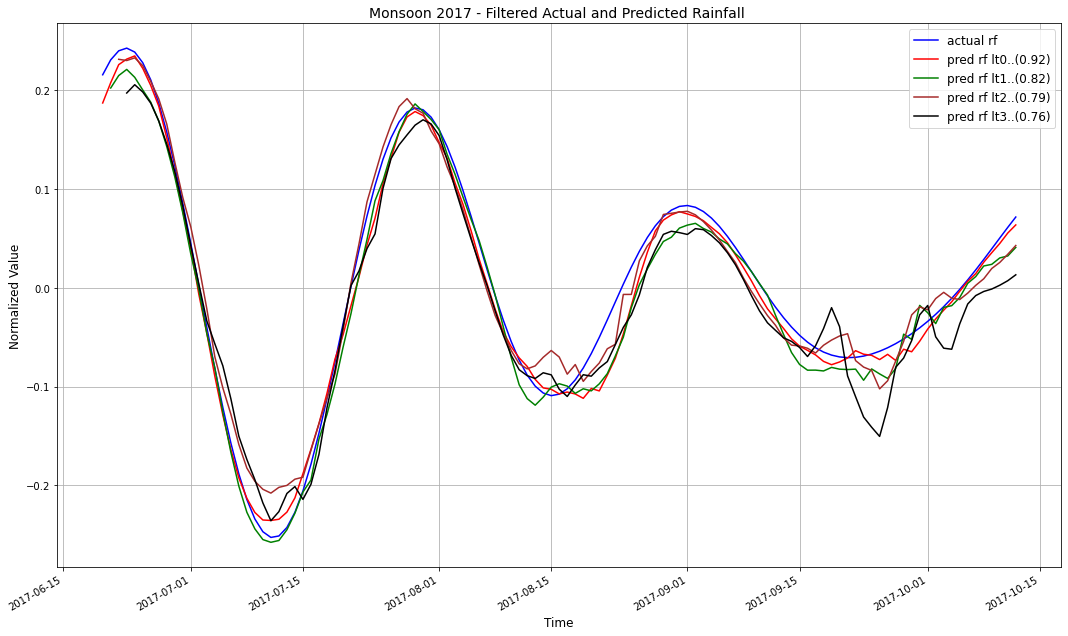

In [57]:
plt.figure(figsize=[18,10])

# Plot filtered rainfall data
rainfall_mean =rf_mean
filtered_rf = xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='actual rf ')



pred_mean = pred_seq1.mean(dim = ['lon', 'lat'])
x = pred_mean.time.data
y = pred_mean.data
pred_mean.plot(color = 'r', label='pred rf lt0..(0.92)')

pred_mean = pred_seq2.mean(dim = ['lon', 'lat'])
y = pred_mean.data
pred_mean.plot(color = 'g', label='pred rf lt1..(0.82)')


pred_mean = pred_seq3.mean(dim = ['lon', 'lat'])
y = pred_mean.data
pred_mean.plot(color = 'brown', label='pred rf lt2..(0.79)')


pred_mean = pred_seq4.mean(dim = ['lon', 'lat'])
y = pred_mean.data
pred_mean.plot(color = 'black', label='pred rf lt3..(0.76)')

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title("Monsoon 2017 - Filtered Actual and Predicted Rainfall ", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
#plt.savefig("CombinedSSTRF2017.png")
